# Experiment with multiple system scores

In this notebook we simulate situation where we have multiple system scores. 

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import itertools
import numpy as np

import json

from rsmtool.utils.prmse import prmse_true

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('../data/data.csv')
config = json.load(open('settings.json'))
df_systems = pd.read_csv('../data/systems.csv')
df_raters = pd.read_csv('../data/raters.csv')

In [3]:
total_n_systems = sum(config['n_systems'])
total_n_systems

30

## Trivial. 

Let's first look at a random pair of average raters and how are systems compare.

In [4]:
human = df_raters[df_raters['category']=='average']['rater_id'].sample(n=2, random_state=32626).values
df['human'] = df[human].mean(axis=1)
h_corr = pearsonr(df[human[0]], df[human[1]])[0]
print("We selected {} and {} with HH correlation = {}".format(human[0], human[1], h_corr))

We selected h_131 and h_101 with HH correlation = 0.5935047407378804


In [5]:
system_columns = df_systems['system_id']

In [6]:
df_true = df[system_columns].corrwith(df['true'])
df_human = df[system_columns].corrwith(df['human'])
df_corr = pd.concat([df_true, df_human], axis=1)
df_corr.columns=['corr_true', 'corr_human']

In [7]:
df_corr_with_category = pd.merge(df_corr, df_systems, left_index=True, right_on='system_id')
df_corr_with_category.index = df_corr_with_category['system_id']
df_corr_long = pd.melt(df_corr_with_category, id_vars = ['system_id', 'exp_r2_true'], value_vars=['corr_true', 'corr_human'],
                       var_name = 'reference', value_name='r')

Text(0.5, 1.0, 'Correlation with the same pair of raters')

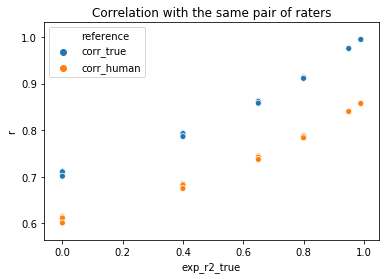

In [8]:
ax=sns.scatterplot(x='exp_r2_true', y='r', hue='reference', data=df_corr_long)
ax.set_title("Correlation with the same pair of raters")

In [9]:
# r2 for individual systems
r2_systems= []
for s in system_columns:
    r2_systems.append(r2_score(df['human'], df[s]))
r2_systems = pd.Series(r2_systems, index=system_columns, name='r2_human')

In [10]:
# r2 with true score for individual systems
r2_true= []
for s in system_columns:
    r2_true.append(r2_score(df['true'], df[s]))
r2_true = pd.Series(r2_true, index=system_columns, name='r2_true')

In [11]:
# prmse for individual systems
prmse = []
for s in system_columns:
    prmse.append(prmse_true(df[s], df[human]))
prmse = pd.Series(prmse, index=system_columns, name='prmse_true')

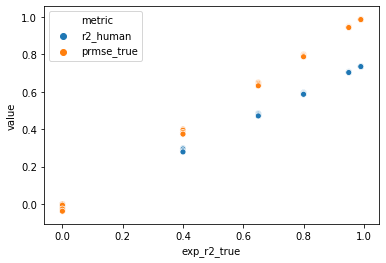

In [14]:
df_r2 = pd.concat([prmse, r2_systems, r2_true, df_corr_with_category], axis=1)
df_r2_long = pd.melt(df_r2, id_vars = ['system_id', 'exp_r2_true'], value_vars=['r2_human', 'prmse_true'],
                     var_name = 'metric', value_name='value')
ax=sns.scatterplot(x='exp_r2_true', y='value', hue='metric', data=df_r2_long)
#ax2 = ax.twinx()
#sns.lineplot(data=df_r2['corr_human'], ax=ax2, color="r", marker='o', sort=False)

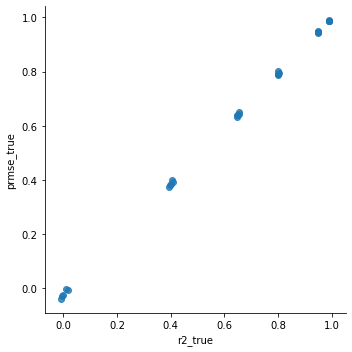

In [15]:
# show how prmse relates to r2_true
sns.lmplot(x='r2_true', y='prmse_true', data=df_r2, fit_reg=False)

## Compare different system on different pairs

In [18]:
# generate pairs of raters for each group

def generate_rater_pairs_for_group(df_group):
    raters = df_group['rater_id']
    # get all possible rater pairs
    rater_pairs = ['{}+{}'.format(p[0], p[1]) for p in itertools.combinations(raters, 2)]
    return rater_pairs

In [19]:
# generate all possible pairs from each group and flatten them
selected_pairs = df_raters.groupby('category').apply(generate_rater_pairs_for_group)
all_pairs = [p for category in selected_pairs for p in category]
len(all_pairs)

4900

In [20]:
# randomly sample a pair for each system
N_pairs = total_n_systems
np.random.seed(14436323)
final_selected_pairs = np.random.choice(all_pairs, N_pairs, replace=False)
len(final_selected_pairs)

30

In [21]:
out = []
for i in range(total_n_systems):
    if i+1 % 10 == 0:
        print('{}/{}'.format(i, total_n_systems))
    humans = final_selected_pairs[i].split('+')
    system = system_columns[i]
    mean = df[humans].mean(axis=1)
    corr = pearsonr(df[system], mean)[0]
    corr_human =  pearsonr(df[humans[0]], df[humans[1]])[0]
    corr_true = pearsonr(df[system], df['true'])[0]
    r2 = r2_score(mean, df[system])
    r2_true = r2_score(df['true'], df[system])
    prmse = prmse_true(df[system], df[humans])
    res = pd.DataFrame({'humans': final_selected_pairs[i],
                        'h1': humans[0],
                        'corr': corr,
                        'system': system,
                        'corr_human': corr_human,
                        'corr_true': corr_true,
                        'degradation': corr - corr_human,
                       'r2_observed': r2,
                        'r2_true': r2_true,
                       'prmse': prmse},
                       index=[system])
    out.append(res)
df_res = pd.concat(out)

0/30
10/30
20/30


In [22]:
# here we assume that the pairs are always drawn from the same groups of raters
df_res_with_category = pd.merge(df_res, df_raters, left_on='h1', right_on='rater_id' )
df_res_all = pd.merge(df_res_with_category, df_systems, left_on='system', right_on='system_id')

In [23]:
df_res_with_category['category'].value_counts()

low         10
moderate     8
average      6
high         6
Name: category, dtype: int64

In [24]:
pd.crosstab(df_res_all['exp_r2_true'], df_res_all['category'])

category,average,high,low,moderate
exp_r2_true,,,,
0.00,1,3,1,0
0.40,2,0,2,1
0.65,0,1,2,2
0.80,0,1,2,2
0.95,2,1,1,1
0.99,1,0,2,2


In [25]:
df_res_all.groupby(['exp_r2_true', 'category'])['corr'].mean().unstack()

category,average,high,low,moderate
exp_r2_true,,,,
0.00,0.609332,0.666670,0.520450,NaN
0.40,0.682707,NaN,0.589759,0.662898
0.65,NaN,0.807380,0.647722,0.721627
0.80,NaN,0.855006,0.686053,0.768200
0.95,0.842207,0.916592,0.741411,0.817110
0.99,0.859389,NaN,0.751421,0.833721


In [27]:
df_res_long = df_res_all.melt(id_vars = ['humans', 'corr_human', 'category', 'system', 'exp_r2_true'],
                                         value_vars = ['corr', 'corr_true', 'degradation',
                                                      'r2_observed', 'prmse'],
                                          var_name = 'metric', value_name = 'value')

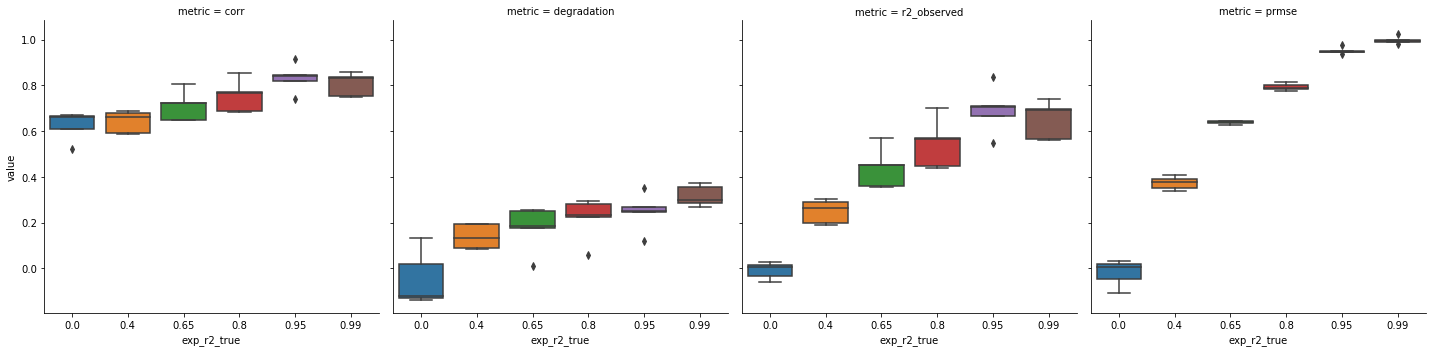

In [56]:
ax = sns.catplot(col='metric', y='value', x='exp_r2_true',
                  data=df_res_long[df_res_long['metric'].isin(['prmse','r2_observed', 'corr', 'degradation'])],
                kind='box')